In [5]:
%pip install --quiet tifffile 

Note: you may need to restart the kernel to use updated packages.


Google Earth Engine successfully initialized.
GEE API Version: 1.5.19
Preparing individual GEE images...
Data preparation complete.
Fetching and saving patches to 'gee_patches_output'...
  Processing location 1: Summit...
    Saved all arrays to a single file: 'gee_patches_output/patch_0.npz'
  Processing location 2: Paradise...
    Saved all arrays to a single file: 'gee_patches_output/patch_1.npz'
  Processing location 3: Sunrise...
    Saved all arrays to a single file: 'gee_patches_output/patch_2.npz'

All patches fetched and saved successfully.
Visualizing data for: Summit
  DEM array shape: (256, 256)
  Optical array shape: (256, 256, 3)
  Thermal array shape: (256, 256)
  SAR array shape: (256, 256)


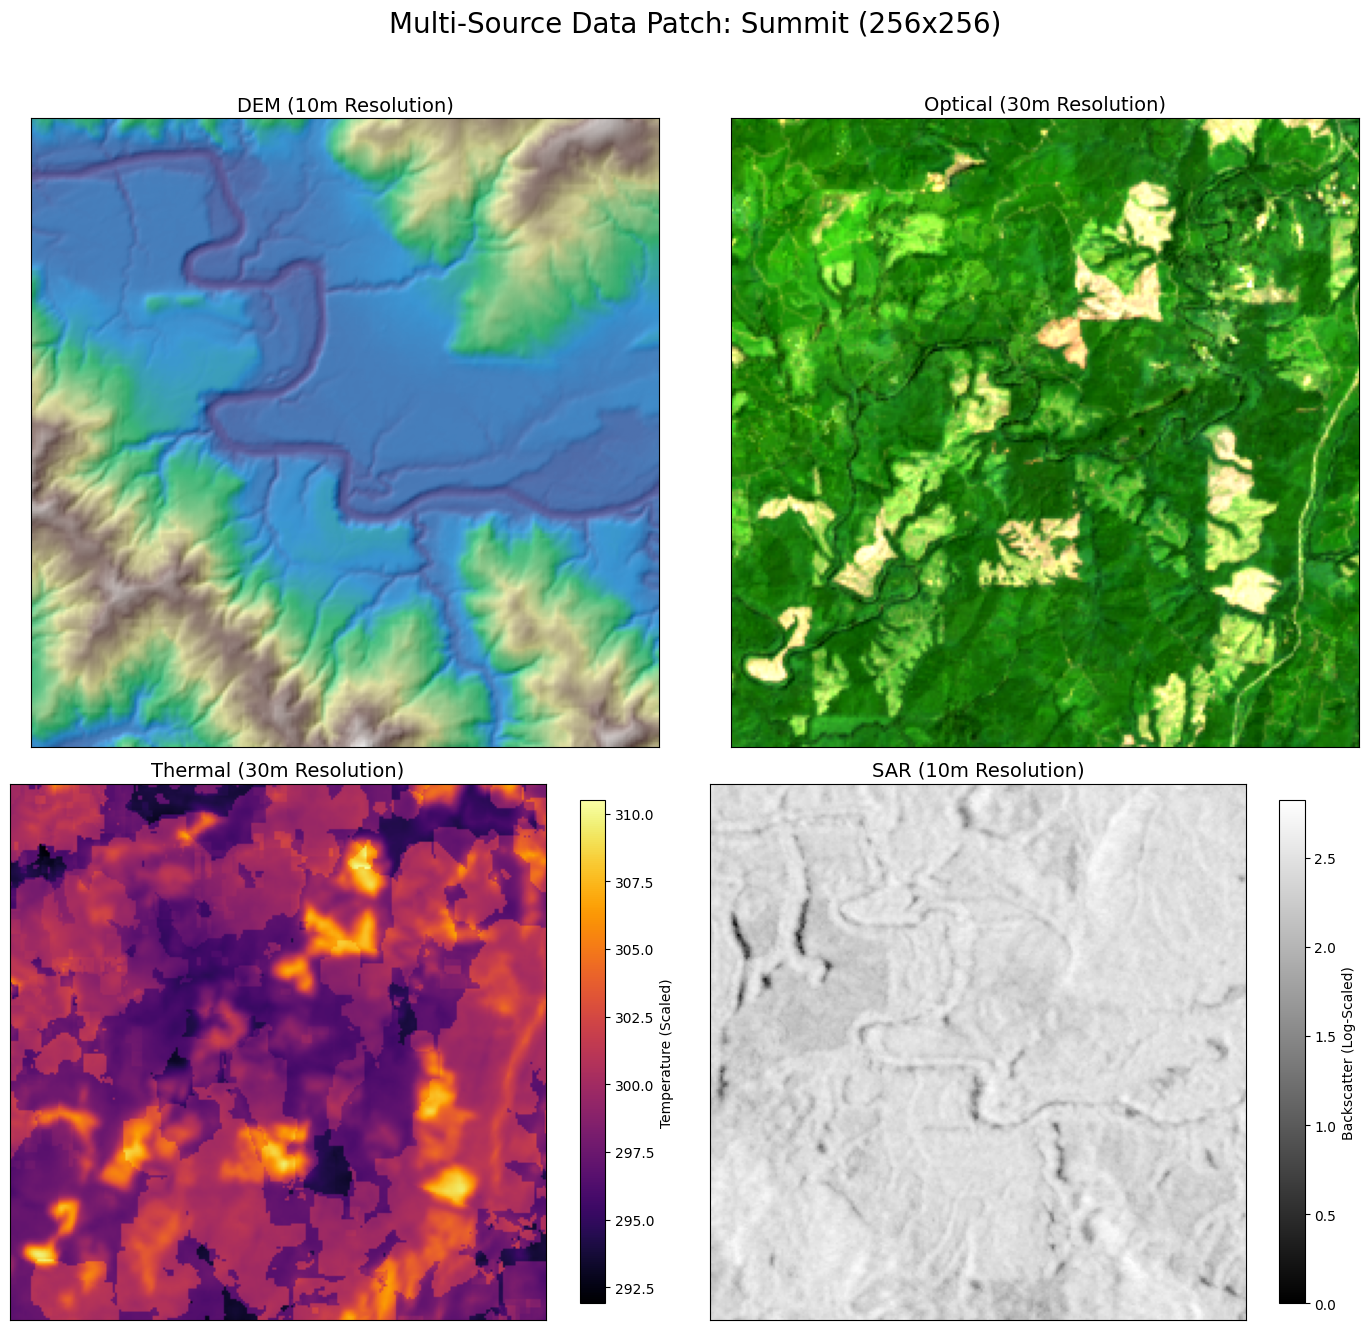

Loading data from: gee_patches_output/patch_0.npz

Successfully loaded arrays from the .npz file:
  - Key: 'dem', Shape: (256, 256)
  - Key: 'optical', Shape: (256, 256, 3)
  - Key: 'thermal', Shape: (256, 256)
  - Key: 'sar', Shape: (256, 256)


In [6]:
# %% [markdown]
# # GEE: Processing Multi-Source Patches into Separate Arrays
# 
# This notebook demonstrates a complete workflow for processing patches from multiple data sources (DEM, Landsat Optical/Thermal, SAR) and fetching them as **separate NumPy arrays**, each at its native resolution.
# 
# The key steps are:
# 1.  **Initialize GEE**: Connect to the Earth Engine platform.
# 2.  **Define Parameters**: Specify locations, patch size, and native resolutions for each source.
# 3.  **Prepare Data Sources**: Load and process each data source to create analysis-ready `ee.Image` objects.
# 4.  **Fetch & Save Patches**: Iterate through a list of center points, fetching a separate array from each data source and saving them together into a single, compressed `.npz` file for each location.
# 5.  **Visualize**: Use Matplotlib to display all the fetched data layers for a sample location.

# %%
# ## Cell 1: Import necessary libraries
import ee
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

# New libraries for a more robust fetching method
import requests
import io
import tifffile


# %% [markdown]
# ## Cell 2: Authenticate and Initialize Google Earth Engine
# 
# If this is your first time running this, you may need to authenticate. Uncomment and run the `ee.Authenticate()` line. After authenticating once, you can comment it out for future runs.

# %%
try:
    # ee.Authenticate() # Uncomment for first-time use
    ee.Initialize(project='nathanj-national-ml')
    print("Google Earth Engine successfully initialized.")
    print(f"GEE API Version: {ee.__version__}")
except Exception as e:
    print(f"Error initializing GEE: {e}")
    print("Please make sure you have authenticated and have a valid GEE account.")

# %% [markdown]
# ## Cell 3: Helper Function to Fetch a Clean Patch
# 
# This function is the core of our data fetching. It is designed to handle both single-band and multi-band images, returning a clean NumPy array.

# %%
def fetch_patch_as_numpy(image: ee.Image, center_point: ee.Feature, patch_size: int, scale: float) -> np.ndarray:
    """
    Fetches a single, clean, rectangular patch directly as a NumPy array.
    This version uses getDownloadURL and handles multi-band images.

    Args:
        image: The GEE Image to sample from.
        center_point: The ee.Feature representing the patch center.
        patch_size: The desired edge dimension of the patch in pixels.
        scale: The native resolution of the image in meters.

    Returns:
        A NumPy array of the patch data, or None if the fetch fails.
    """
    image_proj = image.projection()
    
    # Create a square patch geometry centered on the point
    patch_radius_meters = patch_size * scale / 2.0
    patch_area = center_point.geometry().transform(image_proj, 1) \
                             .buffer(patch_radius_meters, 1) \
                             .bounds(1, image_proj)
    
    try:
        # Use getDownloadURL to get a GeoTIFF of the exact dimensions requested
        url = image.getDownloadURL({
            'region': patch_area,
            'dimensions': f'{patch_size}x{patch_size}',
            'format': 'GEO_TIFF'
        })
        
        # Download the file content
        response = requests.get(url)
        response.raise_for_status()
        
        # Read the GeoTIFF content from memory into a NumPy array
        with io.BytesIO(response.content) as f:
            np_array = tifffile.imread(f)
        
        # Ensure array is float32. For multi-band, tifffile might return (bands, H, W).
        # We check and transpose to the standard (H, W, bands) format.
        if np_array.ndim == 3 and np_array.shape[0] < np_array.shape[1]:
             np_array = np.transpose(np_array, (1, 2, 0))

        return np_array.astype(np.float32)

    except Exception as e:
        print(f"Could not fetch patch: {e}")
        return None

# %% [markdown]
# ## Cell 4: Data Preparation Functions
# 
# This section contains functions to prepare our data sources by creating median composite images.

# %%
def _mask_l8sr_clouds(image: ee.Image) -> ee.Image:
    """Cloud-masks a Landsat 8/9 Collection 2 SR image."""
    cloud_shadow_bit_mask = 1 << 4
    clouds_bit_mask = 1 << 3
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0).And(qa.bitwiseAnd(clouds_bit_mask).eq(0))
    
    # Apply a scaling factor to the optical and thermal bands.
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_band = image.select('ST_B10').multiply(0.00341802).add(149.0)
    
    return image.addBands(optical_bands, None, True).addBands(thermal_band, None, True).updateMask(mask)

def get_landsat_composite(region: ee.Geometry, start_date: str, end_date: str) -> dict:
    """Gets a median composite for Landsat optical and thermal bands."""
    landsat_col = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
        .filterBounds(region) \
        .filterDate(start_date, end_date) \
        .map(_mask_l8sr_clouds)
    
    optical_median = landsat_col.select(['SR_B4', 'SR_B3', 'SR_B2']).median()
    thermal_median = landsat_col.select('ST_B10').median()
    return {'optical': optical_median, 'thermal': thermal_median}

def get_sar_composite(region: ee.Geometry, start_date: str, end_date: str) -> ee.Image:
    """Gets a median composite for Sentinel-1 SAR."""
    sar_col = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(region) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .select('VV')
    return sar_col.median()

# %% [markdown]
# ## Cell 5: Define Parameters & Prepare Images
# 
# Here we define our parameters and then call the preparation functions to create the four analysis-ready `ee.Image` objects.

# %%
# --- Parameters to Modify ---
PATCH_SIZE = 256
START_DATE = '2022-06-01'
END_DATE = '2022-09-30'
TARGET_FOLDER = 'gee_patches_output' # Define the main output folder

# Define the native resolution for each data source
SOURCE_RESOLUTIONS = {
    'dem': 10,
    'optical': 30,
    'thermal': 30,
    'sar': 10
}

# Define a list of center points around Mount Rainier
center_points_list = [
    {'name': 'Summit', 'lat': 46.8529, 'lon': -123.7604},
    {'name': 'Paradise', 'lat': 46.7860, 'lon': -121.7352},
    {'name': 'Sunrise', 'lat': 46.9144, 'lon': -121.6433}
]
# THE FIX: Iterate over 'center_points_list' instead of the variable being created.
center_point_features = [ee.Feature(ee.Geometry.Point([p['lon'], p['lat']])) for p in center_points_list]
aoi = ee.FeatureCollection(center_point_features).geometry().buffer(10000)

print("Preparing individual GEE images...")
# --- Prepare all 4 data sources ---
dem_image = ee.Image('USGS/3DEP/10m').select('elevation')
landsat_composites = get_landsat_composite(aoi, START_DATE, END_DATE)
optical_image = landsat_composites['optical']
thermal_image = landsat_composites['thermal']
sar_image = get_sar_composite(aoi, START_DATE, END_DATE)

print("Data preparation complete.")

# %% [markdown]
# ## Cell 6: Main Loop - Fetch and Save Patches to `.npz`
# 
# This is the main execution block. We iterate through our list of center points, fetch a separate patch from all four data sources, and save them together into a single compressed `.npz` file for each location.

# %%
all_patches_data = []

print(f"Fetching and saving patches to '{TARGET_FOLDER}'...")
os.makedirs(TARGET_FOLDER, exist_ok=True) # Ensure the main output directory exists

for i, center_feature in enumerate(center_point_features):
    patch_name = center_points_list[i]['name']
    print(f"  Processing location {i+1}: {patch_name}...")
    
    # Fetch a patch from each data source at its native resolution
    dem_array = fetch_patch_as_numpy(dem_image, center_feature, PATCH_SIZE, SOURCE_RESOLUTIONS['dem'])
    optical_array = fetch_patch_as_numpy(optical_image, center_feature, PATCH_SIZE, SOURCE_RESOLUTIONS['optical'])
    thermal_array = fetch_patch_as_numpy(thermal_image, center_feature, PATCH_SIZE, SOURCE_RESOLUTIONS['thermal'])
    sar_array = fetch_patch_as_numpy(sar_image, center_feature, PATCH_SIZE, SOURCE_RESOLUTIONS['sar'])
    
    # Create a dictionary of the fetched arrays for saving and visualization
    patch_data = {
        'dem': dem_array,
        'optical': optical_array,
        'thermal': thermal_array,
        'sar': sar_array,
        'name': patch_name
    }
    all_patches_data.append(patch_data)
    
    # --- Save all arrays for this patch into ONE compressed .npz file ---
    # We first remove any arrays that failed to download (are None)
    arrays_to_save = {key: arr for key, arr in patch_data.items() if isinstance(arr, np.ndarray)}
    
    if arrays_to_save:
        # Create the file path directly in the target folder with the patch index
        file_path = os.path.join(TARGET_FOLDER, f'patch_{i}.npz')
        np.savez_compressed(file_path, **arrays_to_save)
        print(f"    Saved all arrays to a single file: '{file_path}'")
    
print(f"\nAll patches fetched and saved successfully.")

# %% [markdown]
# ## Cell 7: Visualize the Output Arrays
# 
# We visualize all four data layers for one location to verify the results before training.

# %%
# Choose which patch to visualize (0 = Summit, 1 = Paradise, etc.)
patch_to_visualize = all_patches_data[0]
name = patch_to_visualize['name']

print(f"Visualizing data for: {name}")

# Extract the arrays from the dictionary
dem_viz = patch_to_visualize['dem']
optical_viz = patch_to_visualize['optical']
thermal_viz = patch_to_visualize['thermal']
sar_viz = patch_to_visualize['sar']

# --- Create Visualization Figure ---
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
plt.suptitle(f'Multi-Source Data Patch: {name} ({PATCH_SIZE}x{PATCH_SIZE})', fontsize=20)

# --- 1. DEM Hillshade ---
ax = axes[0, 0]
if dem_viz is not None:
    print(f"  DEM array shape: {dem_viz.shape}")
    ls = LightSource(azdeg=315, altdeg=45)
    hillshade = ls.hillshade(dem_viz, vert_exag=0.5, dx=10, dy=10)
    ax.imshow(hillshade, cmap='gray')
    ax.imshow(dem_viz, cmap='terrain', alpha=0.6)
ax.set_title('DEM (10m Resolution)', fontsize=14)

# --- 2. Optical (RGB) ---
ax = axes[0, 1]
if optical_viz is not None:
    print(f"  Optical array shape: {optical_viz.shape}")
    rgb_display = optical_viz
    p2, p98 = np.percentile(rgb_display, (2, 98))
    rgb_normalized = np.clip((rgb_display - p2) / (p98 - p2), 0, 1)
    ax.imshow(rgb_normalized)
ax.set_title('Optical (30m Resolution)', fontsize=14)

# --- 3. Thermal ---
ax = axes[1, 0]
if thermal_viz is not None:
    print(f"  Thermal array shape: {thermal_viz.shape}")
    im = ax.imshow(thermal_viz, cmap='inferno')
    fig.colorbar(im, ax=ax, label='Temperature (Scaled)', shrink=0.8)
ax.set_title('Thermal (30m Resolution)', fontsize=14)

# --- 4. SAR ---
ax = axes[1, 1]
if sar_viz is not None:
    print(f"  SAR array shape: {sar_viz.shape}")
    sar_log = np.log1p(sar_viz - np.min(sar_viz))
    im = ax.imshow(sar_log, cmap='gray')
    fig.colorbar(im, ax=ax, label='Backscatter (Log-Scaled)', shrink=0.8)
ax.set_title('SAR (10m Resolution)', fontsize=14)

for ax in axes.flat:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# %% [markdown]
# ## Cell 8: How to Load the `.npz` file
# 
# This cell demonstrates how you would load the multi-resolution data for a single patch back into your deep learning script.

# %%
# Get the path to the first patch we created
# The file is now named based on its index, e.g., 'patch_0.npz'
file_path_to_load = os.path.join(TARGET_FOLDER, 'patch_0.npz')

if os.path.exists(file_path_to_load):
    print(f"Loading data from: {file_path_to_load}")
    
    # Load the .npz file. It acts like a dictionary.
    loaded_data = np.load(file_path_to_load)
    
    # You can access each array by its key
    dem_loaded = loaded_data['dem']
    optical_loaded = loaded_data['optical']
    # ...and so on for the other arrays.
    
    print("\nSuccessfully loaded arrays from the .npz file:")
    for key in loaded_data.keys():
        print(f"  - Key: '{key}', Shape: {loaded_data[key].shape}")
else:
    print("Could not find .npz file to load.")



Loading patch from: /u/nathanj/national_ml/data/script/pipeline_output/patch_dataset/10020007/patch_765.npz


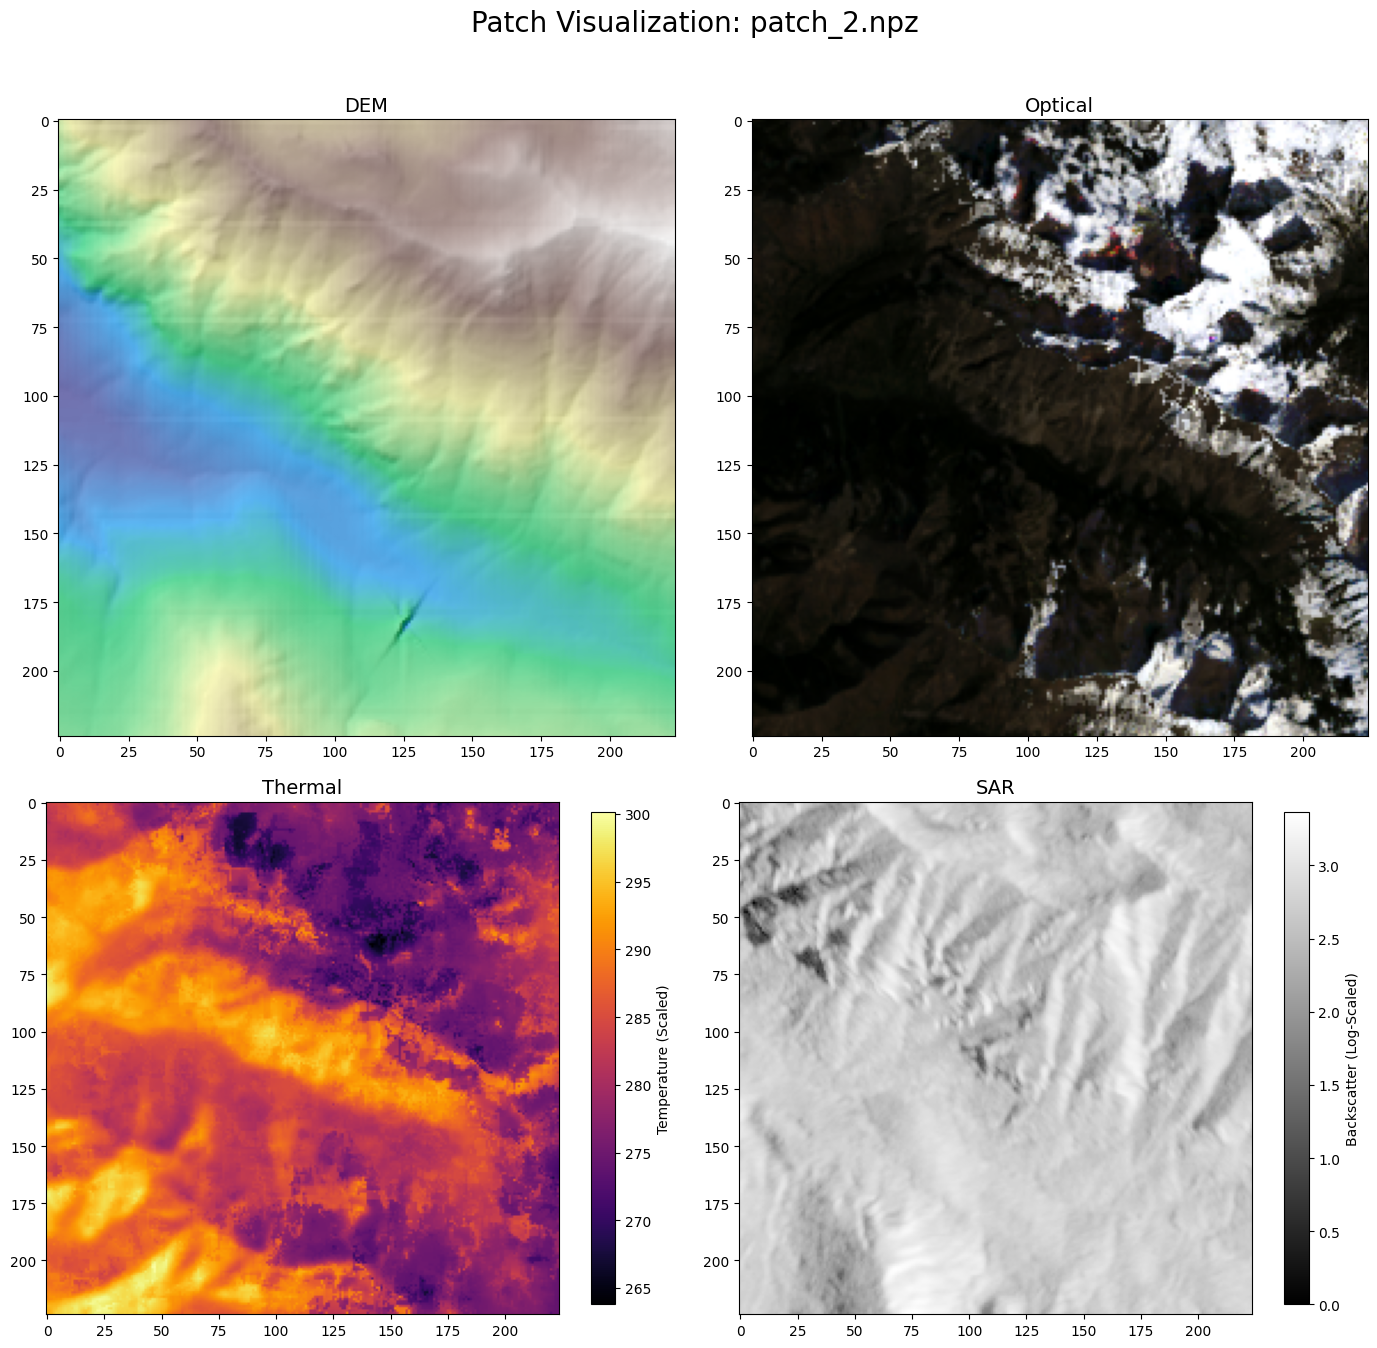

In [13]:
# Load and visualize the patch from the specified .npz file path
patch_file_path = "/u/nathanj/national_ml/data/script/pipeline_output/patch_dataset/10020007/patch_765.npz"

if os.path.exists(patch_file_path):
    print(f"Loading patch from: {patch_file_path}")
    patch_data = np.load(patch_file_path)
    
    # Extract arrays if present
    dem = patch_data['dem'] if 'dem' in patch_data else None
    optical = patch_data['optical'] if 'optical' in patch_data else None
    thermal = patch_data['thermal'] if 'thermal' in patch_data else None
    sar = patch_data['sar'] if 'sar' in patch_data else None

    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    plt.suptitle('Patch Visualization: patch_2.npz', fontsize=20)

    # DEM
    ax = axes[0, 0]
    if dem is not None:
        ls = LightSource(azdeg=315, altdeg=45)
        hillshade = ls.hillshade(dem, vert_exag=0.5, dx=10, dy=10)
        ax.imshow(hillshade, cmap='gray')
        ax.imshow(dem, cmap='terrain', alpha=0.6)
    ax.set_title('DEM', fontsize=14)
    # ax.set_xticks([]); ax.set_yticks([])

    # Optical
    ax = axes[0, 1]
    if optical is not None:
        p2, p98 = np.percentile(optical, (2, 98))
        rgb_normalized = np.clip((optical - p2) / (p98 - p2), 0, 1)
        ax.imshow(rgb_normalized)
    ax.set_title('Optical', fontsize=14)
    # ax.set_xticks([]); ax.set_yticks([])

    # Thermal
    ax = axes[1, 0]
    if thermal is not None:
        im = ax.imshow(thermal, cmap='inferno')
        fig.colorbar(im, ax=ax, label='Temperature (Scaled)', shrink=0.8)
    ax.set_title('Thermal', fontsize=14)
    # ax.set_xticks([]); ax.set_yticks([])

    # SAR
    ax = axes[1, 1]
    if sar is not None:
        sar_log = np.log1p(sar - np.min(sar))
        im = ax.imshow(sar_log, cmap='gray')
        fig.colorbar(im, ax=ax, label='Backscatter (Log-Scaled)', shrink=0.8)
    ax.set_title('SAR', fontsize=14)
    # ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print(f"File not found: {patch_file_path}")

/tmp/ipykernel_3305309/590519936.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


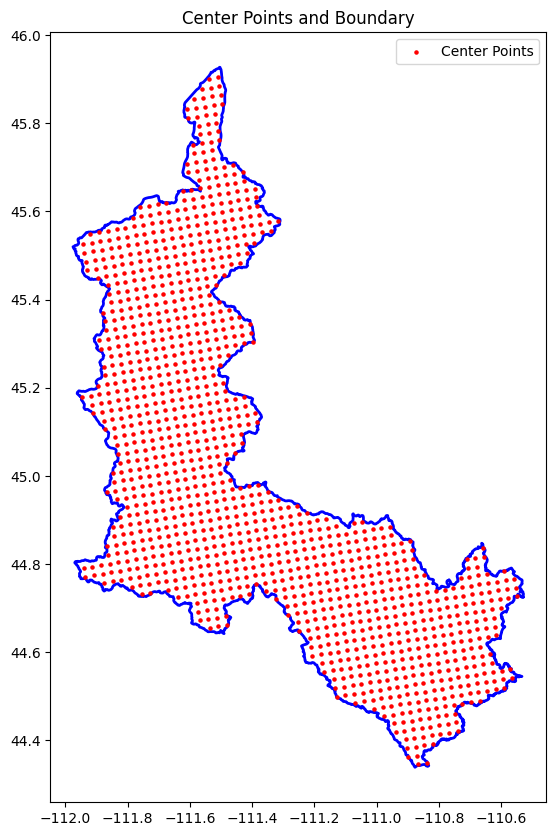

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON files
center_points_gdf = gpd.read_file("/u/nathanj/national_ml/data/script/pipeline_output/huc_processing/10020007/huc8_10020007_center_points_features.geojson")
boundary_gdf = gpd.read_file("/u/nathanj/national_ml/data/script/pipeline_output/huc_processing/10020007/huc8_10020007_boundary.geojson")

# Plot both layers
fig, ax = plt.subplots(figsize=(10, 10))
boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, label='Boundary')
center_points_gdf.plot(ax=ax, color='red', markersize=5, label='Center Points')

ax.set_title("Center Points and Boundary")
ax.legend()
plt.show()

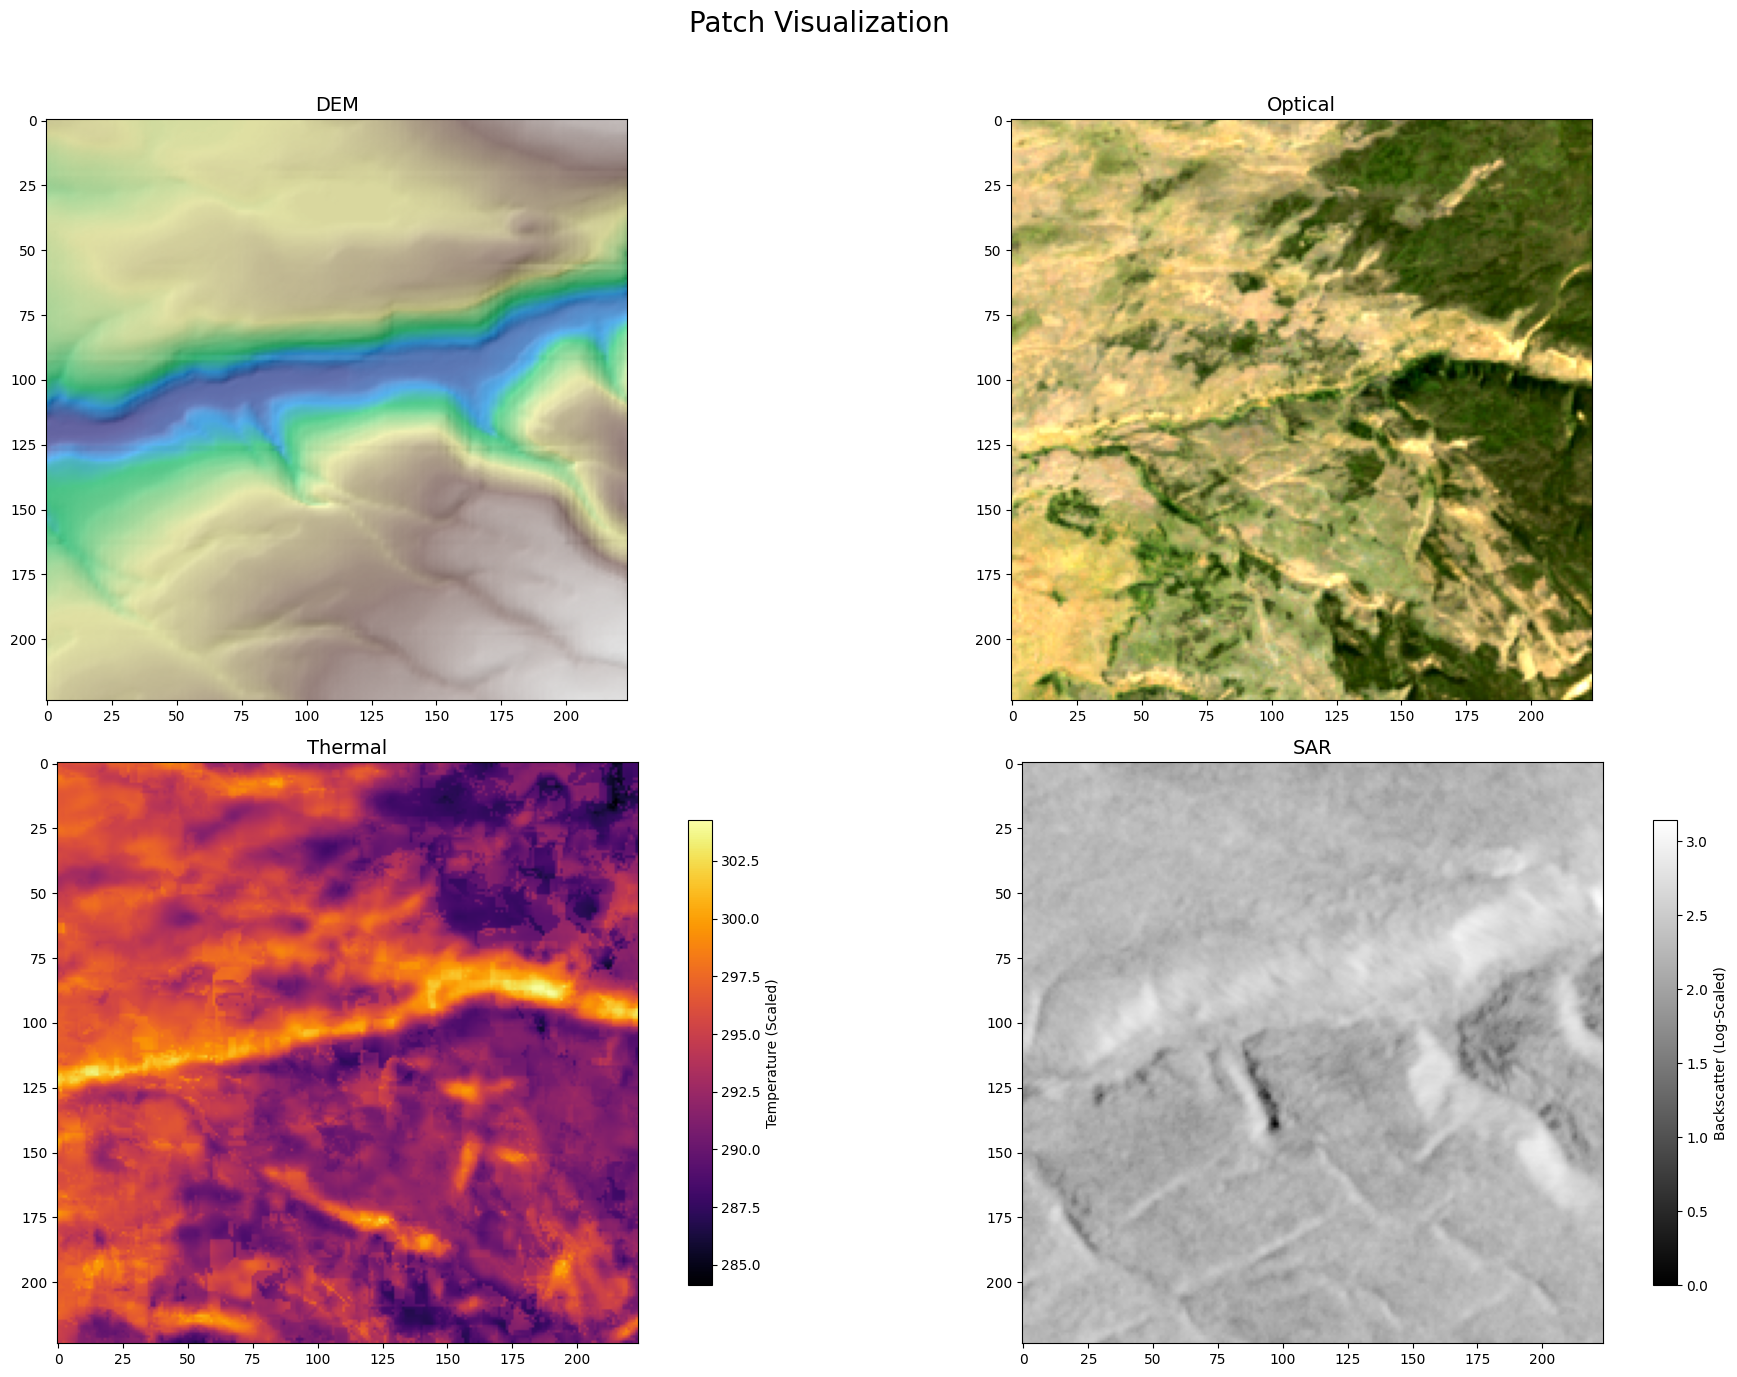

In [43]:
# Load the patch arrays from the specified .npz file
patch_file_path = "/u/nathanj/national_ml/data/script/pipeline_output/patch_dataset/10020007/patch_200.npz"

if os.path.exists(patch_file_path):
    patch_data = np.load(patch_file_path)
    dem = patch_data['dem'] if 'dem' in patch_data else None
    optical = patch_data['optical'] if 'optical' in patch_data else None
    thermal = patch_data['thermal'] if 'thermal' in patch_data else None
    sar = patch_data['sar'] if 'sar' in patch_data else None
    hydro_mask = patch_data['hydro_mask'] if 'hydro_mask' in patch_data else None
    flow_dir = patch_data['flow_dir'] if 'flow_dir' in patch_data else None

    # Visualize the loaded patch arrays (dem, optical, thermal, sar, hydro_mask, flow_dir) if available
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    plt.suptitle('Patch Visualization', fontsize=20)

    # DEM
    ax = axes[0, 0]
    if dem is not None:
        ls = LightSource(azdeg=315, altdeg=45)
        hillshade = ls.hillshade(dem, vert_exag=0.5, dx=10, dy=10)
        ax.imshow(hillshade, cmap='gray')
        ax.imshow(dem, cmap='terrain', alpha=0.6)
    ax.set_title('DEM', fontsize=14)

    # Optical
    ax = axes[0, 1]
    if optical is not None:
        p2, p98 = np.percentile(optical, (2, 98))
        rgb_normalized = np.clip((optical - p2) / (p98 - p2), 0, 1)
        ax.imshow(rgb_normalized)
    ax.set_title('Optical', fontsize=14)

    # Thermal
    ax = axes[1, 0]
    if thermal is not None:
        im = ax.imshow(thermal, cmap='inferno')
        fig.colorbar(im, ax=ax, label='Temperature (Scaled)', shrink=0.8)
    ax.set_title('Thermal', fontsize=14)

    # SAR
    ax = axes[1, 1]
    if sar is not None:
        sar_log = np.log1p(sar - np.min(sar))
        im = ax.imshow(sar_log, cmap='gray')
        fig.colorbar(im, ax=ax, label='Backscatter (Log-Scaled)', shrink=0.8)
    ax.set_title('SAR', fontsize=14)

    # # Hydro Mask
    # ax = axes[1, 1]
    # if hydro_mask is not None:
    #     im = ax.imshow(hydro_mask, cmap='Blues')
    #     fig.colorbar(im, ax=ax, label='Hydro Mask', shrink=0.8)
    # ax.set_title('Hydro Mask', fontsize=14)

    # # Flow Direction
    # ax = axes[1, 2]
    # if flow_dir is not None:
    #     im = ax.imshow(flow_dir, cmap='twilight')
    #     fig.colorbar(im, ax=ax, label='Flow Direction', shrink=0.8)
    # ax.set_title('Flow Direction', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print(f"File not found: {patch_file_path}")

ModelTransformationTag: (0.00012660488833349134, 0.0, 0.0, -110.93096137267099, 0.0, -8.997359378180095e-05, 0.0, 44.71656456256494, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)
GeoKeyDirectoryTag: (1, 1, 2, 3, 1024, 0, 1, 2, 1025, 0, 1, 1, 2048, 0, 1, 4269)
All TIFF tags: [256, 257, 258, 259, 262, 277, 282, 283, 296, 322, 323, 324, 325, 339, 34264, 34735]
Array shape: (224, 224), dtype: float32


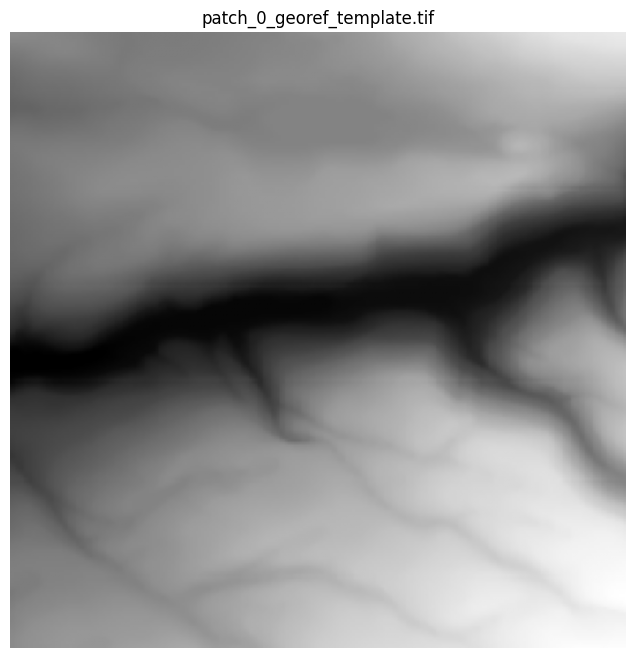

In [44]:
import tifffile
import numpy as np

import matplotlib.pyplot as plt

tif_path = "/u/nathanj/national_ml/data/script/pipeline_output/patch_dataset/10020007/patch_200_georef_template.tif"

with tifffile.TiffFile(tif_path) as tif:
    # Print CRS and projection info if available
    if tif.pages[0].tags.get('GeoASCIIParamsTag'):
        print("GeoASCIIParamsTag:", tif.pages[0].tags['GeoASCIIParamsTag'].value)
    if tif.pages[0].tags.get('ModelTransformationTag'):
        print("ModelTransformationTag:", tif.pages[0].tags['ModelTransformationTag'].value)
    if tif.pages[0].tags.get('ModelTiepointTag'):
        print("ModelTiepointTag:", tif.pages[0].tags['ModelTiepointTag'].value)
    if tif.pages[0].tags.get('ModelPixelScaleTag'):
        print("ModelPixelScaleTag:", tif.pages[0].tags['ModelPixelScaleTag'].value)
    if tif.pages[0].tags.get('GeoKeyDirectoryTag'):
        print("GeoKeyDirectoryTag:", tif.pages[0].tags['GeoKeyDirectoryTag'].value)
    # Print all keys for inspection
    print("All TIFF tags:", list(tif.pages[0].tags.keys()))

with tifffile.TiffFile(tif_path) as tif:
    arr = tif.asarray()

print(f"Array shape: {arr.shape}, dtype: {arr.dtype}")

plt.figure(figsize=(8, 8))
if arr.ndim == 2:
    plt.imshow(arr, cmap='gray')
elif arr.ndim == 3 and arr.shape[0] in [1, 3, 4]:
    # (bands, H, W) -> (H, W, bands)
    arr_disp = np.transpose(arr, (1, 2, 0))
    if arr_disp.shape[2] >= 3:
        plt.imshow(arr_disp[..., :3])
    else:
        plt.imshow(arr_disp[..., 0], cmap='gray')
else:
    plt.imshow(arr, cmap='gray')
plt.title("patch_0_georef_template.tif")
plt.axis('off')
plt.show()